**Course**: [_Systèmes dynamiques en biologie_](https://moodle.epfl.ch/course/info.php?id=14291) (BIO-341)

**Professor**: _Felix Naef_

SSV, BA5, 2022

In [5]:
#import important libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.integrate import odeint
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# The diffusion equation

The goal of this exercise is to study dynamical models that involve both space and time (so-called Partial Differential Equation: PDE).



## Simple diffusion

In the absence of drift, _i.e._ when the molecules are not moving on average, the diffusion equation is defined as 

\begin{equation}
\frac{\partial p\left(x,t\right)}{\partial t}=D\frac{\partial^{2}p\left(x,t\right)}{\partial x^{2}}\label{eq:Diffusion without drift}
\end{equation}

Let's derive the solution of this equation for an initial condition $p\left(x,0\right)=p_{0}\left(x\right)$ using Fourier transforms.

**Question 1**

Compute the spatial Fourier transform of both sides of the diffusion equation. The spatial Fourier transform of an arbitrary function $h$ is defined as : 

\begin{equation}
H(k)=\mathcal{F}\left[h\right](k)=\int_{-\infty}^{+\infty}h(x)e^{-ikx}\mathrm{d}x\label{eq: Fourier transform}
\end{equation}


**Hint**: $\mathcal{F}\left[\frac{\partial^{n}}{\partial x^{n}}h(x)\right]\left(k\right)=\left(ik\right)^{n}H(k)$

(You can prove it using the definition above)

>Left side gives $\int\frac{\partial p\left(x,t\right)}{\partial t}e^{-ikx}\mathrm{d}x=\frac{\partial}{\partial t}\int p\left(x,t\right)e^{-ikx}\mathrm{d}x=\frac{\partial P\left(k,t\right)}{\partial t}$  

>Right side gives $\int D\frac{\partial^{2}p\left(x,t\right)}{\partial x^{2}}e^{-ikx}\mathrm{d}x=D\int\frac{\partial^{2}p\left(x,t\right)}{\partial x^{2}}e^{-ikx}\mathrm{d}x=D\left(ik\right)^{2}P\left(k,t\right)=-Dk^{2}P\left(k,t\right)$  

>The transformed equation is $\frac{\partial P\left(k,t\right)}{\partial t}=-Dk^{2}P\left(k,t\right)$.


**Question 2**

Solve the linear ordinary differential equation for $P(k,t)=\mathcal{F}\left[p(x,t)\right](k)$ with the transformed initial condition $P_0(k)$.



>Using separation of variables combined with the provided initial condition, one obtains $P\left(k,t\right)=P_{0}(k)e^{-Dk^{2}t}$.

**Question 3**

For $p_{0}(x)=\delta(x)$ (the Dirac delta-function) and using the inverse Fourier transform, defined as:

\begin{equation}
h(x)=\mathcal{F}^{-1}\left[H\right](x)=\frac{1}{2 \pi}\int_{-\infty}^{+\infty}H(k)e^{ikx}\mathrm{d}k \, ,
\end{equation}

compute the solution in the spatial domain and plot it for different values of $t$ with $D=1$. 

**Note:**

$\delta(x)$ is an infinitely thin and sharp function such that $\delta(x) = 0$ for $x \neq 0$ and $\int \delta(x) f(x)dx = f(0)$.
		
__Hint__: $\mathcal{F}\left[\frac{e^{-\frac{x^{2}}{a}}}{\sqrt{\pi a}}\right](k)=e^{-\frac{k^{2}a}{4}}$. Again, you can prove this hint using the definition of Fourier Transform.


>$P\left(k,t\right)=e^{-\frac{-k^{2}4Dt}{4}}$gives $p\left(x,t\right)=\frac{1}{\sqrt{4\pi Dt}}e^{-\frac{x^{2}}{4Dt}}$

>(from the hint $a=4Dt$). This is a Gaussian function with 0 mean and $4Dt$ variance 

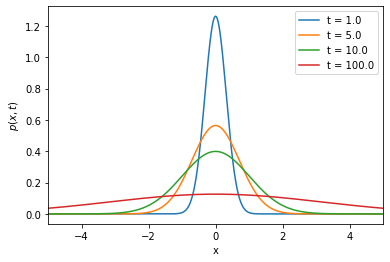

In [6]:
x = np.linspace(-10,10,10000)
D=0.05
for s in [100,500, 1000,10000]:
    t=s*10**(-2)
    plt.plot(x, 1/(4*np.pi*D*t)**0.5*np.exp(-x**2/(4*D*t)), label = "t = " + str(t))
    
plt.xlim(-5,5)
plt.xlabel('x')
plt.ylabel(r'$p(x,t)$')
plt.legend()
plt.show()
plt.close()

## The morphogen gradient

The concept of morphogen gradient is central in developmental biology. A morphogen gradient is a gradient of molecules that determines the shape and structure of the developing organism. A notable example is the Bicoid (Bcd) gradient in _D. melanogaster_, where the exponential gradient of Bcd transcription factor activates downstream genes, resulting in the specification of the anterior-posterior axis of the fly embryo. Such gradients are typically generated through a combination of localized production, degradation and diffusion mechanisms. 
	
A model for the establishement of a 1D morphogen gradient from a point source at $x=0$ is given by:
	
\begin{equation}
\frac{\partial c }{\partial t}=D\frac{\partial^{2}c }{\partial x^{2}} - \gamma c + s\delta(x)
\end{equation}

where $\gamma$ is the degradation rate and $s$ the production rate. 
	


**Question 1**

Explain each term in the model, and state the units of each parameter.

>First term: Diffusion. 

>Second term: degradation. 

>Third term: production at position $x = 0$. 

>Units: $[D] = \frac{space ^2}{time}, [\gamma] = time ^{-1}$ and $[s] = [c] \frac{space}{time}$

**Question 2**

Find the stationary solution of the morphogen gradient equation. 

**Note**: Stationary means that $\frac{\partial}{\partial t}  c(x,t)  = 0$ or in Fourier space $\frac{\partial}{\partial t}C(k,t) = 0$.
	    
**Hint**: The Fourier transform of $e^{-a|x|}$ is $2\frac{a}{k^2 + a^2}$

>$\frac{\partial}{ \partial t}c = D\frac{\partial^{2}}{\partial x^2}c - \gamma c + s\delta$.

>Taking the spatial Fourier transform on both sides gives:

>$\frac{\partial}{\partial t}C(k,t) = - k^{2}DC(k,t) - \gamma C(k,t) + s$  

>We are looking for steady state (stationary) solution, i.e $\frac{\partial}{\partial t}C(k,t) = 0$, so: 
$0 = -k^2DC(k,t) - \gamma C(k,t) + s$  
Hence: $C(k,t) = \frac{s}{k^2D + \gamma}$  
Now we want to compute the inverse Fourier transform to get the spatial solution. We need to write $C(k,t)$ like $2\frac{a}{k^2 + a^2}$: 
	    	
>$C(k,t) = s\frac{1}{k^2D + \gamma} = \frac{s}{D} \frac{1}{k^2 + \frac{\gamma}{D}} = \frac{s}{D \sqrt{\frac{\gamma}{D}}}\frac{\sqrt{\frac{\gamma}{D}}}{k^2 + \frac{\gamma}{D}} = \frac{s}{2D \sqrt{\frac{\gamma}{D}}}2\frac{\sqrt{\frac{\gamma}{D}}}{k^2 + \frac{\gamma}{D}}$ 
	    	
>Then we apply the Fourier transform formula with $a= \sqrt{\frac{\gamma}{D}}$:  
$c(x,t) = \frac{s}{2D\sqrt{\frac{\gamma}{D}}}e^{-\sqrt{\frac{\gamma}{D}}|x|}$

### Exam sample question (paper and pencil)
#### Diffusion

The concentration profile $c(x,t)$ of a protein is determined by the following 1-dimensional diffusion equation 
$$
\frac{\partial}{\partial t}c(x,t) = D \frac{\partial^2}{\partial^2 x} c(x,t) - \mu \frac{\partial}{\partial x} c(x,t)
$$
with $\mu<0$.

The profile at time $t_0$ is shown in the figure below. Sketch the profile for two time points $t>t_0$.

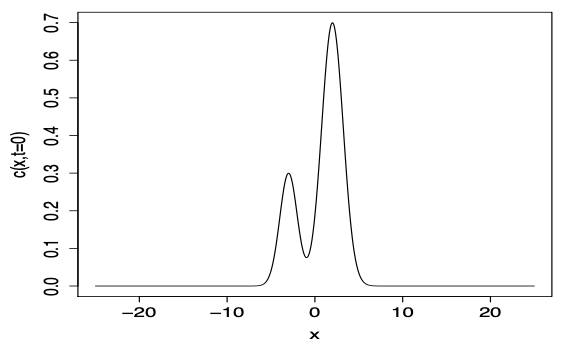


> You can solve the equation above for a simpler initial condition, for example a Dirac delta, as you did in the first part of the notebook. You will find that the second term $-\mu \frac{\partial}{\partial x} c(x,t)$ corresponds to a drift with velocity $\mu$. From that we can deduce a qualitative behaviour for our initial condition.

>We can write our equation in the Fourier space, where
$$
\frac{\partial c(x,t)}{\partial t} \rightarrow \frac{\partial}{\partial t}C(k,t)
$$

$$
\frac{\partial^2 c(x,t)}{\partial^2 x} \rightarrow -k^2 C(k,t)
$$

$$
\frac{\partial c(x,t)}{\partial x} \rightarrow ik C(k,t)
$$

$$ 
\frac{\partial}{\partial t}C(k,t) = -D k^2 C(k,t) - i \mu k C(k,t) = - (Dk^2+i\mu k) C(k,t) 
$$
>The solution in Fourier space is
$$
C(k,t) = C_0(k) \exp{\left \{ - (Dk^2 + i\mu k) t \right \} }
$$

>where $C_0(k)$ is the initial condition. Let's consider $C_0(k)=1$ for a Dirac delta, then the solution in Fourier space reads

$$
C(k,t) = \exp{\left \{ - (Dk^2 + i\mu k) t \right \} }
$$

>Going back to $x$ space and with similar calculations as you did at the beginning of the series we get

$$
c(x,t) = \frac{1}{\sqrt{4\pi Dt}} \exp{\left ( -\frac{(x-\mu t)^2}{4Dt} \right)}
$$

>so we see that the solution is again a Gaussian centered in $\mu t$, so moving with velocity $\mu$ (negative).

>We can deduce that our initial distribution will similarly undergo a drift towards the left (negative $x$ values) together with diffusion, as sketched here

![drift](drift.png)

## FRAP in 1D

A widely used method in cell biology to investigate diffusion phenomena
is called FRAP (Fluorescent Recovery After Photobleaching). It consists
of bleaching a fluorophore (e.g. GFP) in a defined region of the cell
with a high intensity laser beam and observing afterward the recovery
of its fluorescence due to spatial diffusion (other processes can
also contribute and be modeled as well). Here, we will simulate a
1D-FRAP experiment by using Gaussian function as above. FRAP recovery
profiles $r(x,t)$ in 1D can be studied with the approximate expression
\begin{equation}
r\left(x,t\right)=1-\alpha\frac{1}{\sqrt{4\pi\left(Dt+w^{2}\right)}}e^{-\frac{\left(x-x_{0}\right)^{2}}{4\left(Dt+w^{2}\right)}}
\end{equation}
 where $w$ is the size of the bleached region and $\alpha$
the bleaching efficiency. 

**Question 1**

Explain the meaning of $r$.

>This parameter describes the fluorescence signal along $x$ at
time $t$. By comparing $r(x,t)$ to a Gaussian distribution
$p(x)=\frac{1}{\sqrt{2\pi\sigma}}e^{-\frac{\left(x-x_{0}\right)^{2}}{2\sigma^{2}}}$one
finds that the variance is proportional to the time. The recovery
profiles is minimum at the center of the bleached region and its size
increases with time.

**Question 2**

Plot the solution with $x_{0}=0$, $D=1$,
$\mu=0.5$, $\alpha=10$ and $w=1$. Follow its evolution for $t\in\left[0,200\right]$
and $x\in\left[-10,10\right]$. 

In [3]:
#play with the alphas
def frap(t):
    x0=0
    D=1
    mu=0.5
    α=10
    W=1
    x=np.linspace(-10,10,50)
    r=1-α*np.exp(-(x-x0)**2/(4*(D*t+W**2)))/np.sqrt(4*np.pi*(D*t+W**2))
    plt.figure(figsize=(7,7))
    plt.plot(x,r)
    plt.ylim(-2,2)
    plt.xlabel('x')
    plt.ylabel('r')
    plt.show()

In [4]:
interact(frap, t=(0,200,1))

interactive(children=(IntSlider(value=100, description='t', max=200), Output()), _dom_classes=('widget-interac…

<function __main__.frap(t)>

![](Ex12_slider_t5.png)
![](Ex12_slider_t30.png)

**Question 3**

Most of the time, the fluorescence
recovery is often only partial, i.e. it remains lower than the initial
fluorescent intensity even for long times. The part of the fluorescence
that is “missing” is known as the ''immobile fraction''. What could
be the molecular origin of such phenomenon?

> The reason is that not all the remaining fluorescent proteins diffuse.
For example, some receptors in the membrane could be attached to the
underlying cytoskeleton and don’t freely diffuse.